In [1]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, full_gen, df = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/', img_size=(300,300), batch_size=32)

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy\utils

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 576 validated image filenames.
Found 145 validated image filenames.
Found 721 validated image filenames.


x_batch: (32, 300, 300, 3) dtype: float32
min: 0.0 max: 255.0


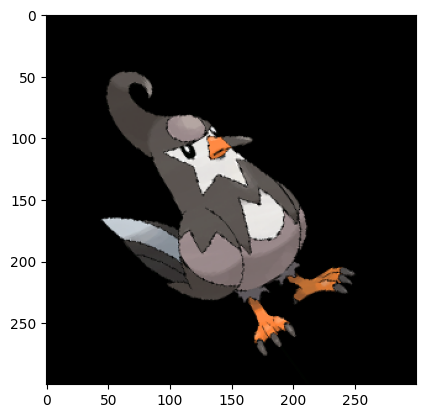

In [11]:
import matplotlib.pyplot as plt
x_batch, y_batch = next(iter(train_gen))
print("x_batch:", x_batch.shape, "dtype:", x_batch.dtype)
print("min:", x_batch.min(), "max:", x_batch.max())

plt.imshow(x_batch[0].astype("uint8") )
# plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3), drop_connect_rate=0.4
)

# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision,Recall, AUC
from tensorflow.keras.regularizers import l2

# freeze the base
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(18, activation='sigmoid')  # 18 is the number of pokemon types so 18 classes
])

model.compile(
    optimizer=Adam(1e-2),
    loss=BinaryCrossentropy(),
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision'), Recall(name='recall')]

)
model.summary()

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,  
    callbacks=[EarlyStopping(
        monitor='val_auc',
        patience=5,
        restore_best_weights=True
    )]
)

Epoch 1/25
18/18 [==============================] - 34s 2s/step - loss: 0.8346 - auc: 0.5544 - precision: 0.1142 - recall: 0.3806 - val_loss: 0.4056 - val_auc: 0.5992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
18/18 [==============================] - 26s 1s/step - loss: 0.4921 - auc: 0.6343 - precision: 0.2849 - recall: 0.1811 - val_loss: 0.5022 - val_auc: 0.5547 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
18/18 [==============================] - 25s 1s/step - loss: 0.4704 - auc: 0.7139 - precision: 0.2929 - recall: 0.2895 - val_loss: 0.4950 - val_auc: 0.5607 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
18/18 [==============================] - 25s 1s/step - loss: 0.4186 - auc: 0.7511 - precision: 0.3675 - recall: 0.3391 - val_loss: 0.4846 - val_auc: 0.5707 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
18/18 [==============================] - 25s 1s/step - loss: 0.3949 - auc: 0.7685 - precision: 0.3733 - recal

23/23 - 21s - loss: 0.3982 - auc: 0.6597 - precision: 0.0000e+00 - recall: 0.0000e+00 - 21s/epoch - 895ms/step
[0.39823123812675476, 0.6597309112548828, 0.0, 0.0]
18/18 - 22s - loss: 0.3945 - auc: 0.6956 - precision: 0.0000e+00 - recall: 0.0000e+00 - 22s/epoch - 1s/step
[0.3945356607437134, 0.6955605745315552, 0.0, 0.0]
5/5 - 5s - loss: 0.4056 - auc: 0.5992 - precision: 0.0000e+00 - recall: 0.0000e+00 - 5s/epoch - 908ms/step
[0.40560412406921387, 0.5991668105125427, 0.0, 0.0]


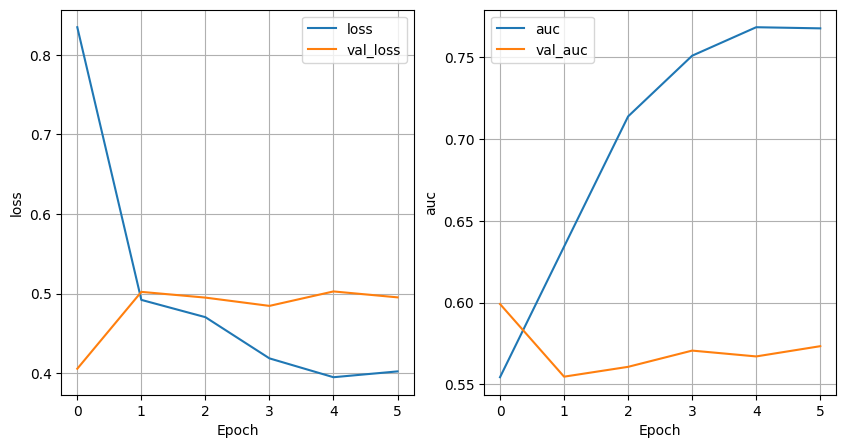

In [15]:
h = history
keys = list(h.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(h.history[keys[idx]], label=keys[idx])
    axes[idx].plot(h.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

print( model.evaluate(full_gen, verbose=2)); 
print( model.evaluate(train_gen, verbose=2)); 
print( model.evaluate(valid_gen, verbose=2)); 
# print("\n\nLoss on test set {:.3},  Categorical accuracy on test set {:.3f}, AUC {:.3f}".format(test_loss, test_acc, auc))

In [ ]:

model.save('../models/est,83auc.h5')
print("✅ Model saved")

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model("../models/poke_efficnet_(224,0.74auc).h5", compile=False)  # load weights

In [ ]:

# 1. Unfreeze last ~30 layers of the base EfficientNet
# (assuming your model = Sequential([base_model, ...]))
base_model.trainable = False

for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# 2. Recompile with a much smaller LR
model.compile(
    optimizer=Adam(5e-6),   # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=[
        AUC(name='auc', multi_label=True),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)


In [ ]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau
# 3. Set callbacks
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

# 4. Train for a smaller number of epochs (since we’re fine-tuning)
history_finetune = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[early_stop, reduce_lr]
)